#### Imports

In [27]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from collections import deque
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import MSE

#### Environment setup

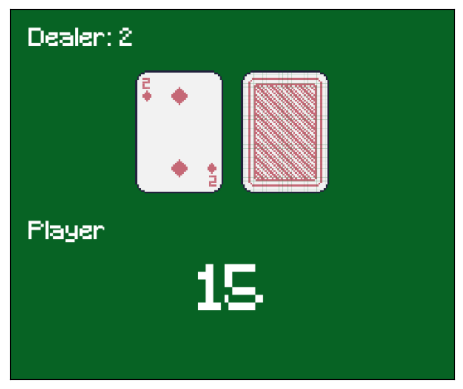

In [2]:
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode = 'rgb_array')
plt.xticks([])
plt.yticks([])
obs, info = env.reset(seed=42)
img = env.render() #creates an image
plt.imshow(img)

The observation consists of a 3-tuple containing: the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1).

In [3]:
print(obs)

(15, 2, False)


There are two actions: stick (0), and hit (1).

In [4]:
env.action_space

Discrete(2)

In [5]:
action = 1

Hit - draw one more card

In [6]:
obs, reward, done, truncated, info = env.step(1)

c:\Users\chris\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
print(obs)
print(reward)
print(done)
print(truncated)
print(info)

(25, 2, False)
-1.0
True
False
{}


#### VERY Basic policy

"Same" as dealer - hit until reach 17

In [8]:
def basic_policy(obs):
    current_sum = obs[0]
    if current_sum < 17:
        return 1
    else:
        return 0

In [9]:
def winning_percentages(wins, episodes):
    return (wins / episodes) * 100

In [10]:
losses = 0
wins = 0
number_of_episodes = 10000
for episode in range(number_of_episodes):
    episode_rewards = 0
    obs, info = env.reset(seed=episode) #different seeds everytime
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    if episode_rewards > 0:
        wins = wins + 1
    else:
        losses = losses + 1

In [11]:
print(f'Wins: {wins} | Losses: {losses} | Win Percentage: {winning_percentages(wins, number_of_episodes)}')

Wins: 4080 | Losses: 5920 | Win Percentage: 40.8


This shows, that a very basic policy of just hitting until you reach at least 17 will net you a win approximately 40% of the time.

### Neural Network

In [40]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0
batch_size = 48
number_of_episodes = 5000
discount_factor = 0.8
optimizer = Nadam(learning_rate = 0.03)
loss_fn = MSE
replay_buffer = deque(maxlen=2000)

In [41]:
input_shape = [3] # Observation Space
n_outputs = 2 # 2 outputs - hit or stand
model = Sequential([
    Input(shape=input_shape),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation = "relu"),
    BatchNormalization(),
    Dense(64, activation = "relu"),
    Dense(n_outputs, activation='linear')
])

In [42]:
def normalize_state(state):
    """Normalize the state values to [0,1] range"""
    player_sum, dealer_card, usable_ace = state
    return np.array([
        player_sum / 31.0,  # max possible sum
        dealer_card / 10.0, # max dealer card
        float(usable_ace)
    ])

In [43]:
def epsilon_greedy_policy(state, epsilon = 0): #choose random action with probability epsilon, otherwise choose best
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) #random action
    else:
        state = np.array(state)
        Q_values = model.predict(state[np.newaxis], verbose = 0)[0]
        return Q_values.argmax()

In [44]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
    #the six are states, actions, rewards, next_states, dones, truncateds

In [45]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = normalize_state(next_state)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [46]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose = 0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs*discount_factor*max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [47]:
def get_win_rate(rewards, number_of_episodes):
    winCount = rewards.count(1.0) + rewards.count(1.5)
    winRate = round((winCount/number_of_episodes)*100, 2)
    return winRate

In [48]:
for episode in range(number_of_episodes): 
    obs, info = env.reset()
    obs = normalize_state(obs)
    episode_rewards=0
    for step in range(200):
        epsilon = max(1-episode/500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        episode_rewards += reward
        if done or truncated:
            break

    rewards.append(episode_rewards)
    winRate = get_win_rate(rewards, episode+1)
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}, Win rate: {winRate}%",
          end="")

    if episode > 200:
        training_step(batch_size)

Episode: 5000, Steps: 1, eps: 0.010, Win rate: 40.18%

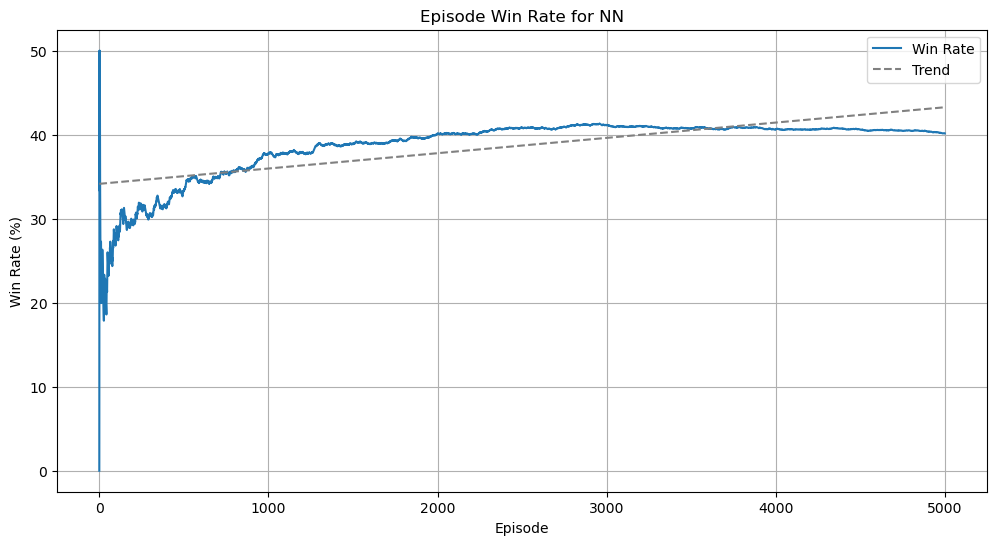

In [49]:
plt.figure(figsize=(12, 6))
winRates = [get_win_rate(rewards[:i], i+1) for i in range(number_of_episodes)]
plt.plot(winRates, label='Win Rate')

# Add a dotted trend line
x = np.arange(number_of_episodes)
trend = np.poly1d(np.polyfit(x, winRates, 1))(x)
plt.plot(x, trend, '--', color='gray', label='Trend')

plt.xlabel('Episode')
plt.ylabel('Win Rate (%)')
plt.title('Episode Win Rate for NN')
plt.legend()
plt.grid()
plt.show()

In [50]:
def evaluate_agent(agent, episodes):
    wins = 0
    draws = 0
    losses = 0
    
    for _ in range(episodes):
        state = env.reset()[0]
        state = normalize_state(state)
        done = False
        
        while not done:
            state = np.array(state)
            action = agent.predict(state[np.newaxis], verbose = 0)[0].argmax()
            next_state, reward, done, _, _ = env.step(action)
            state=next_state
            state = normalize_state(next_state)
            
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1
    
    print(f"\nResults over {episodes} episodes:")
    print(f"Wins: {wins} ({wins/episodes*100:.1f}%)")
    print(f"Draws: {draws} ({draws/episodes*100:.1f}%)")
    print(f"Losses: {losses} ({losses/episodes*100:.1f}%)")

    return round(wins/episodes*100,2), round(draws/episodes*100,2), round(losses/episodes*100,2)
# Evaluate the trained agent
wins, draws, losses = evaluate_agent(model, number_of_episodes)



Results over 5000 episodes:
Wins: 1871 (37.4%)
Draws: 254 (5.1%)
Losses: 2875 (57.5%)


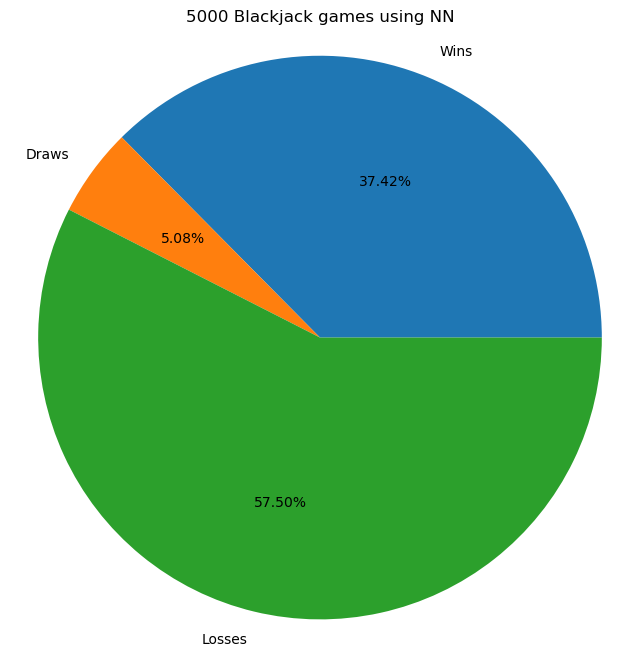

In [51]:
labels = ['Wins', 'Draws', 'Losses']
values = [wins, draws, losses]

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(values, labels=labels, autopct='%1.2f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is circular.
ax.set_title(f'{number_of_episodes} Blackjack games using NN')
plt.show()